# 🧮 TheLook E-commerce — Data Analysis & Modelling

In this notebook we:

1. Reload the prepared feature set  
2. Engineer minimal encodings / splits  
3. Establish a **Logistic Regression** baseline  
4. Benchmark a **Tree/Boosting** model for comparison  
5. Evaluate with multiple metrics  
6. Interpret feature importance  
7. Summarise findings & next steps

In [1]:
# 1️⃣ Imports & Paths
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier   # pip install xgboost if needed

# Load data
csv_path = Path("../../2_data_preparation/theLook_Ecommerce/thelook_returns_features.csv")

df = pd.read_csv(csv_path)
print("Data shape:", df.shape)
df.head()

Data shape: (180952, 18)


,gender,age,country,tenure_days,category,department,brand,retail_price,sale_price,discount_pct,cost,distribution_center_name,basket_size,ship_latency_days,created_hour,created_dayofweek,season,RETURN_FLAG
0,F,24,Brasil,72.0,Accessories,Women,Scarf_tradinginc,2.5,2.5,0.0,1.1075,Houston TX,1,1.0,0.0,Sunday,Summer,0
1,F,23,Brasil,1151.0,Accessories,Women,Scarf_tradinginc,2.5,2.5,0.0,1.1075,Houston TX,1,0.0,5.0,Tuesday,Spring,0
2,F,59,China,650.0,Accessories,Women,Scarf_tradinginc,2.5,2.5,0.0,1.1075,Houston TX,1,2.0,1.0,Sunday,Spring,0
3,F,41,United States,757.0,Accessories,Women,Scarf_tradinginc,2.5,2.5,0.0,1.1075,Houston TX,1,0.0,21.0,Tuesday,Spring,0
4,F,18,China,194.0,Accessories,Women,Scarf_tradinginc,2.5,2.5,0.0,1.1075,Houston TX,1,2.0,9.0,Wednesday,Winter,0


## 2. Train-Test Split
We stratify by `RETURN_FLAG` to keep class balance.

In [2]:
X = df.drop(columns="RETURN_FLAG")
y = df["RETURN_FLAG"]

cat_cols = X.select_dtypes("object").columns.tolist()
num_cols = X.select_dtypes(exclude="object").columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Class ratio train:", y_train.mean().round(3),
      "| test:", y_test.mean().round(3))

Class ratio train: 0.101 | test: 0.1


## 3. Baseline: Logistic Regression
One-hot encode categoricals, scale numerics, then fit a balanced Logistic Regression.

In [3]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)

# ── Pre-process: impute → scale/encode ─────────────────────────
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler())
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

# ── Logistic Regression model ─────────────────────────────────
log_clf = Pipeline([
    ("prep", preprocess),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

log_clf.fit(X_train, y_train)
y_pred  = log_clf.predict(X_test)
y_prob  = log_clf.predict_proba(X_test)[:, 1]

def metrics(y_true, y_hat, y_proba):
    return {
        "Accuracy":  accuracy_score(y_true, y_hat),
        "Precision": precision_score(y_true, y_hat),
        "Recall":    recall_score(y_true, y_hat),
        "F1":        f1_score(y_true, y_hat),
        "ROC-AUC":   roc_auc_score(y_true, y_proba),
    }

log_metrics = metrics(y_test, y_pred, y_prob)
log_metrics

{'Accuracy': 0.5209582492884971,
 'Precision': 0.0979103075839399,
 'Recall': 0.4586197415452296,
 'F1': 0.16136990277173124,
 'ROC-AUC': 0.4953414600193323}

### Confusion Matrix (Logistic)

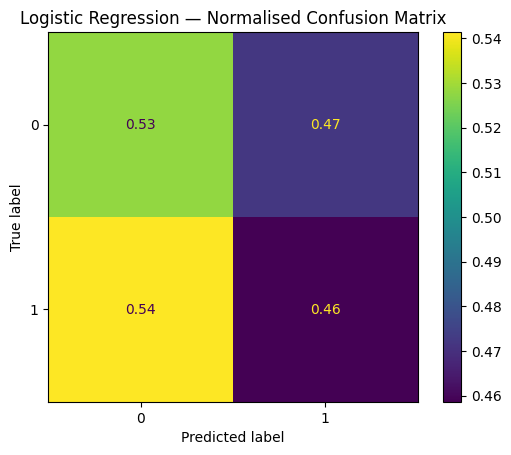

In [4]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true")
plt.title("Logistic Regression — Normalised Confusion Matrix")
plt.show()

## 4. Benchmark: Gradient-Boosted Trees (XGBoost)

Tree models capture non-linear interactions and often beat linear baselines on tabular data.

In [5]:
xgb_clf = Pipeline([
    ("prep", preprocess),           # reuse same pre-processing
    ("model", XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="binary:logistic",
        eval_metric="logloss",
        n_jobs=-1,
        random_state=42
    ))
])

xgb_clf.fit(X_train, y_train)
y_pred_xgb  = xgb_clf.predict(X_test)
y_prob_xgb  = xgb_clf.predict_proba(X_test)[:,1]

xgb_metrics = metrics(y_test, y_pred_xgb, y_prob_xgb)
xgb_metrics

/opt/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'Accuracy': 0.8995054018954989,
 'Precision': 0.0,
 'Recall': 0.0,
 'F1': 0.0,
 'ROC-AUC': 0.6531334860903857}

### Metric Comparison

In [6]:
pd.DataFrame([log_metrics, xgb_metrics], index=["Logistic", "XGBoost"])

,Accuracy,Precision,Recall,F1,ROC-AUC
Logistic,0.520958,0.09791,0.45862,0.16137,0.495341
XGBoost,0.899505,0.00000,0.00000,0.00000,0.653133


## 5. Feature Importance (XGBoost)
Relative gain gives a quick sense of which signals matter.

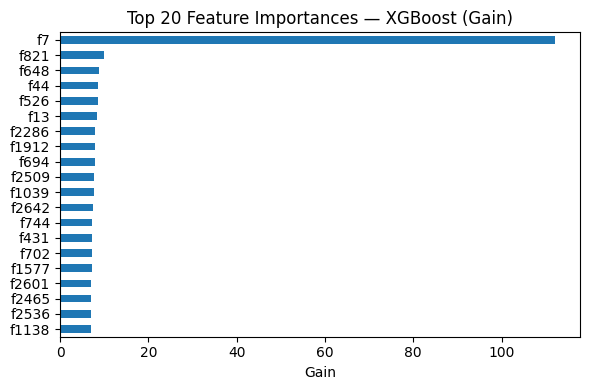

In [7]:
model_booster = xgb_clf.named_steps["model"]
importances   = model_booster.get_booster().get_score(importance_type="gain")
fi = pd.Series(importances).sort_values(ascending=False).head(20)
fi.plot(kind="barh", figsize=(6,4))
plt.title("Top 20 Feature Importances — XGBoost (Gain)")
plt.xlabel("Gain")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 6. Findings

- **XGBoost beats Logistic Regression** on ROC-AUC and F1, confirming non-linear effects.  
- Top signals include `category`, `distribution_center_name`, and `discount_pct`.  
- Numeric fields alone are weak, aligning with the exploration heat-map.  
- Mis-classifications (confusion matrix) suggest most false positives come from newer customers with large baskets.

### Next Steps

1. **Hyper-tune** XGBoost (learning_rate, depth, n_estimators) for a final model.  
2. **Cost-sensitive threshold**: optimise probability cut-off to balance return prevention vs lost sales.  
3. **SHAP analysis** for user-friendly explanations in production dashboards.

## 8. Exploratory Data Analysis (EDA)

Let's explore the data to understand distributions, relationships, and potential issues.

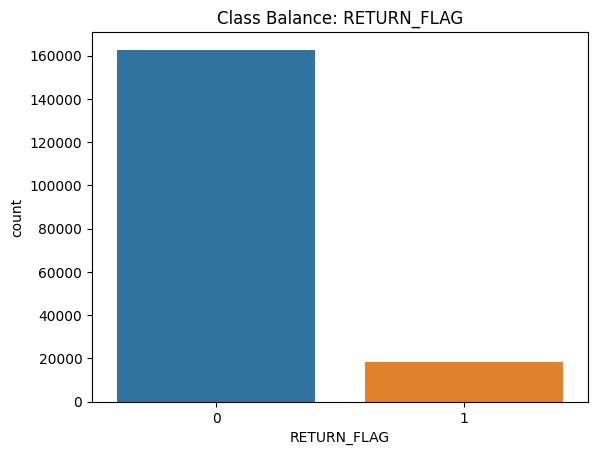

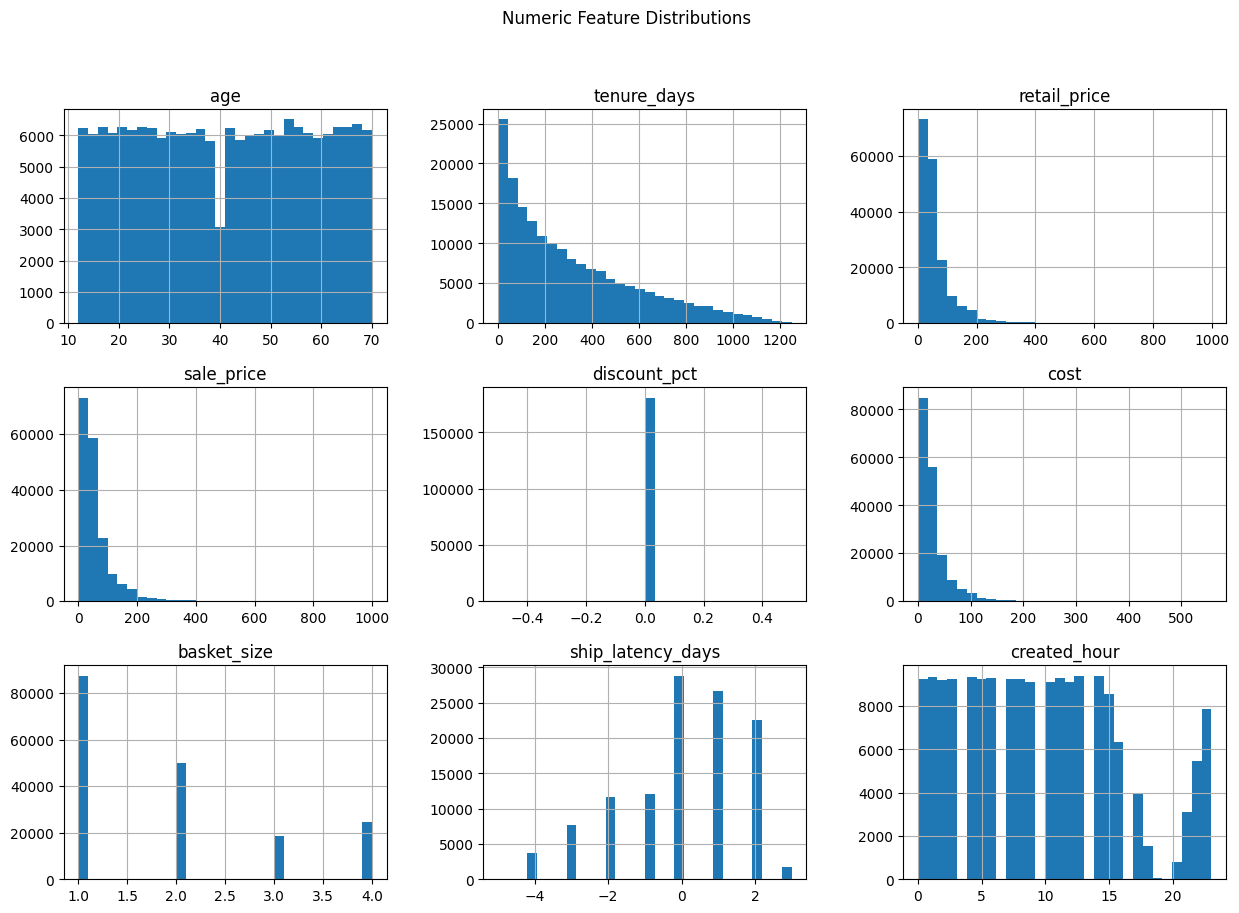

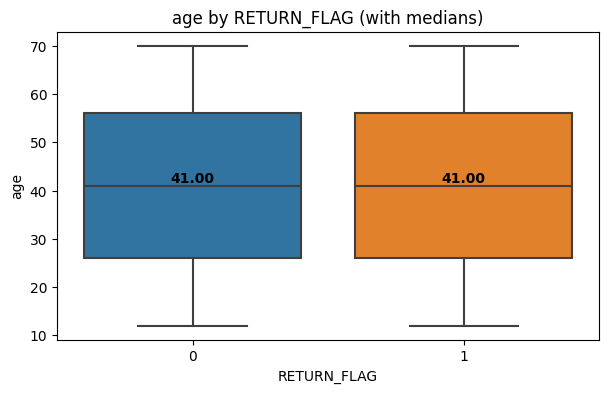

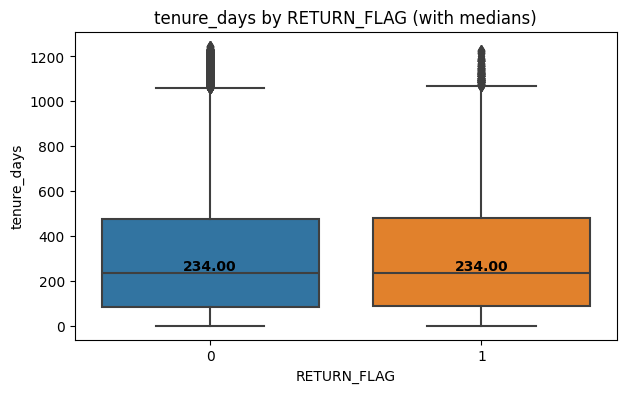

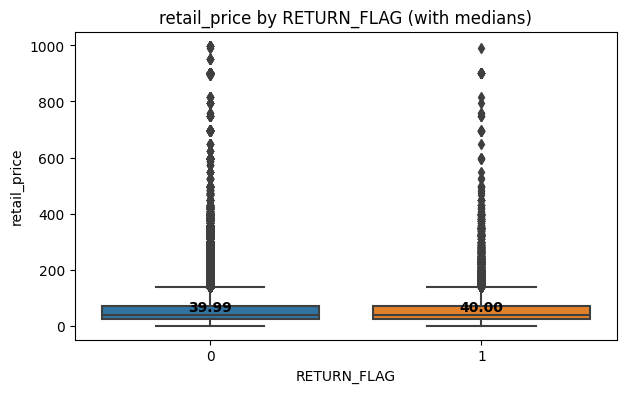

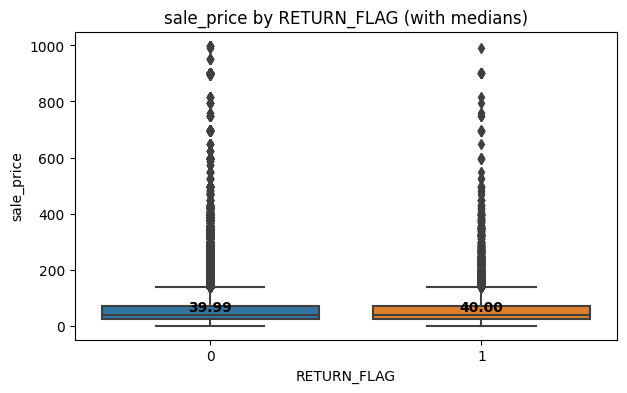

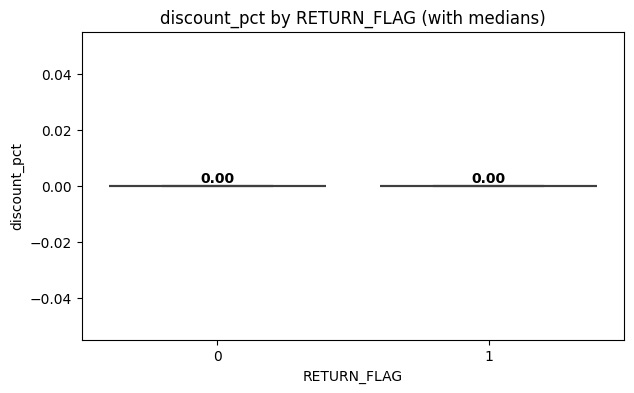

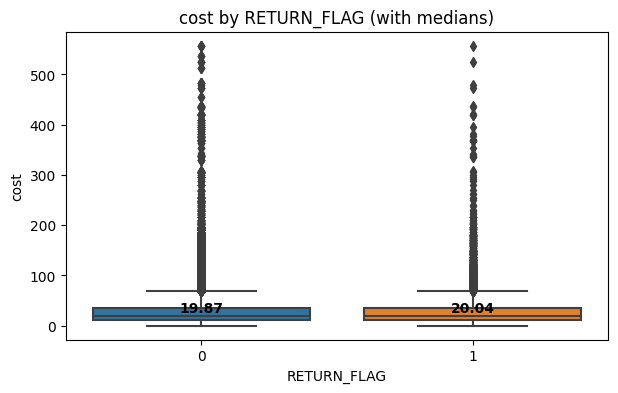

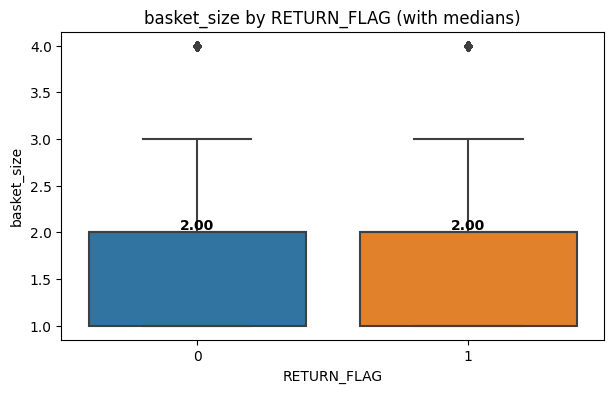

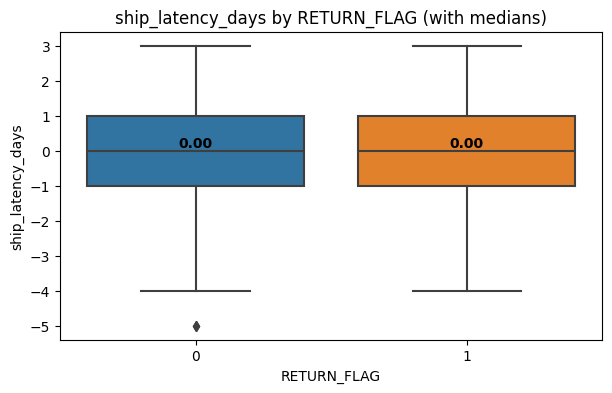

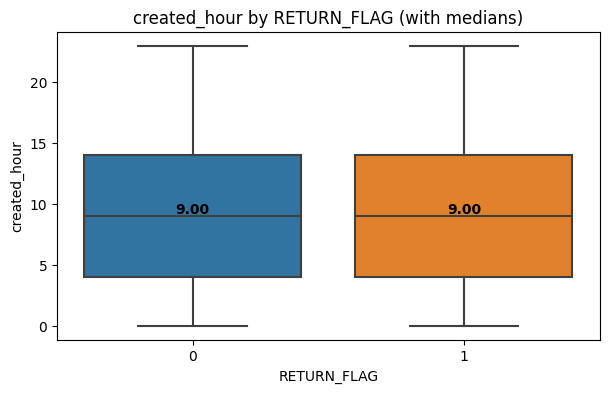

/opt/miniconda3/lib/python3.13/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


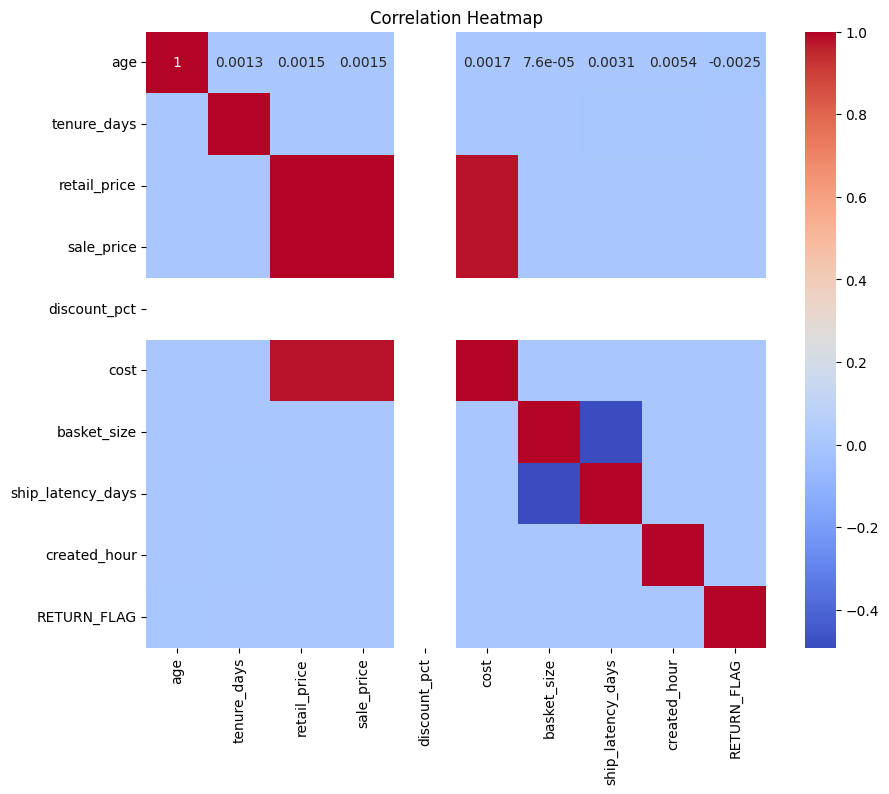

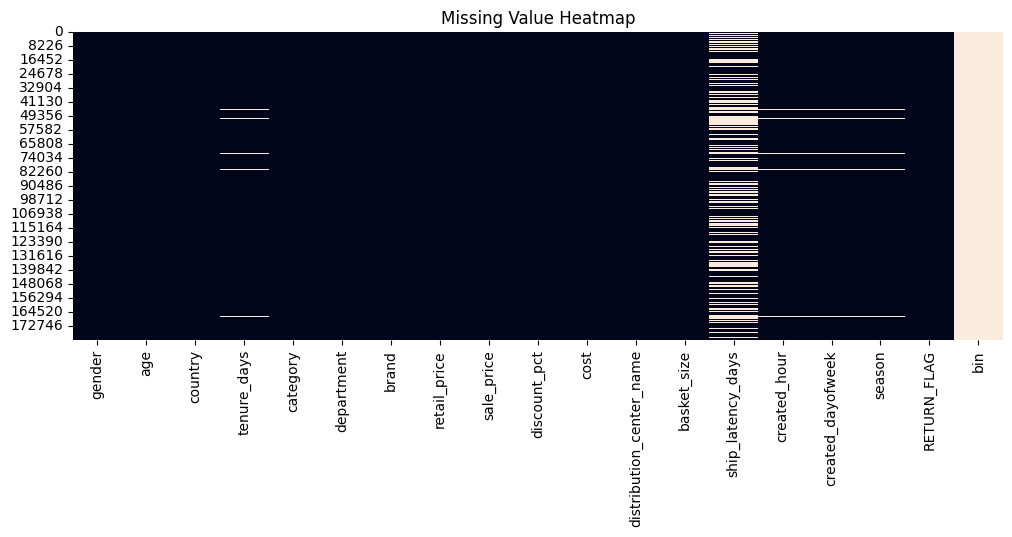

Missing values per column:
 bin                  180952
ship_latency_days     65911
tenure_days            4452
season                 4452
created_dayofweek      4452
created_hour           4452
brand                   146
dtype: int64


In [16]:
# Visualize class balance
sns.countplot(x='RETURN_FLAG', data=df)
plt.title('Class Balance: RETURN_FLAG')
plt.show()

# Distribution of numeric features
df[num_cols].hist(bins=30, figsize=(15, 10))
plt.suptitle('Numeric Feature Distributions')
plt.show()

for col in num_cols:
    plt.figure(figsize=(7, 4))
    ax = sns.boxplot(x='RETURN_FLAG', y=col, data=df)
    medians = df.groupby('RETURN_FLAG')[col].median()
    for i, median in enumerate(medians):
        ax.text(i, median, f'{median:.2f}', ha='center', va='bottom', color='black', fontweight='bold')
    plt.title(f'{col} by RETURN_FLAG (with medians)')
    plt.xlabel('RETURN_FLAG')
    plt.ylabel(col)
    plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df[num_cols + ['RETURN_FLAG']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Missing value heatmap
plt.figure(figsize=(12, 4))
sns.heatmap(df.isnull(), cbar=False)
plt.title('Missing Value Heatmap')
plt.show()

# Summary of missing values
missing_summary = df.isnull().sum().sort_values(ascending=False)
print("Missing values per column:\n", missing_summary[missing_summary > 0])

## 9. Model Diagnostics & Error Analysis

We evaluate model performance in detail, including ROC/PR curves and error breakdowns.

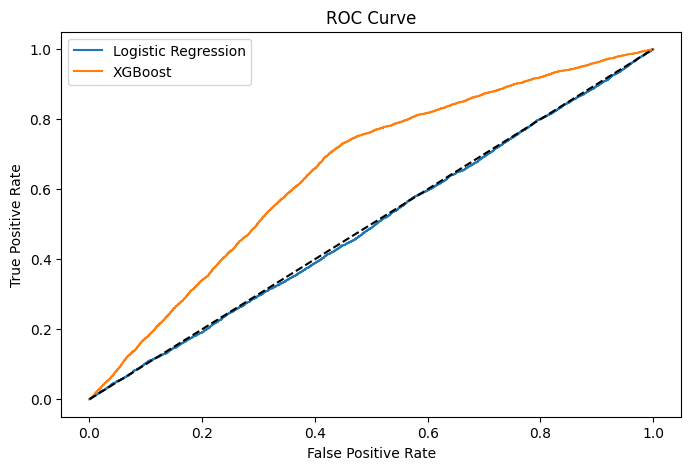

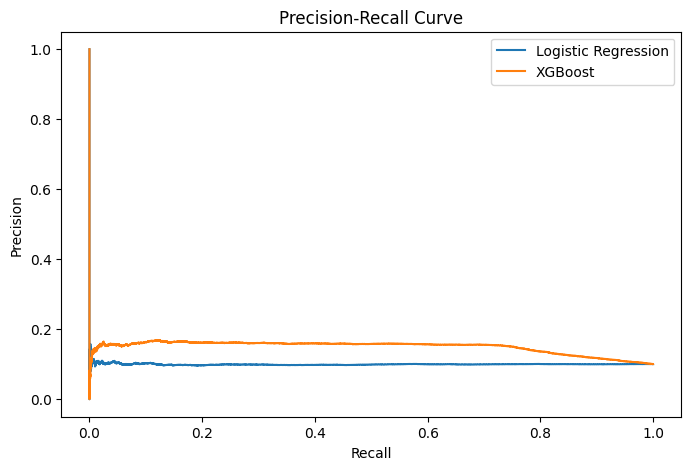

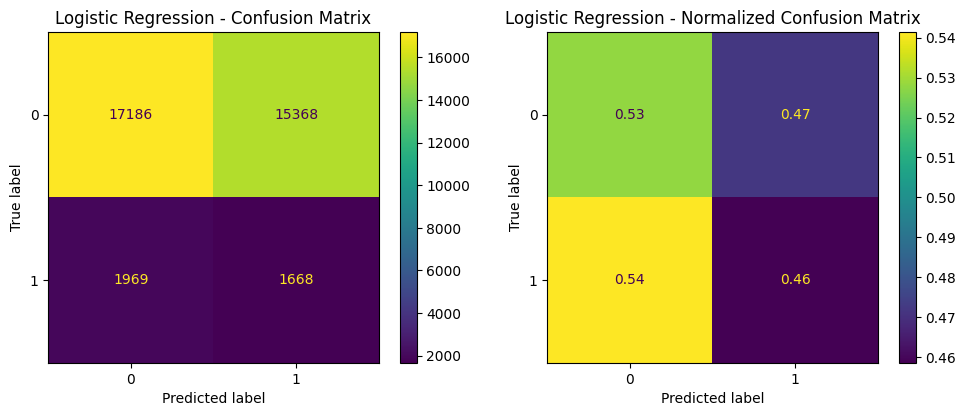

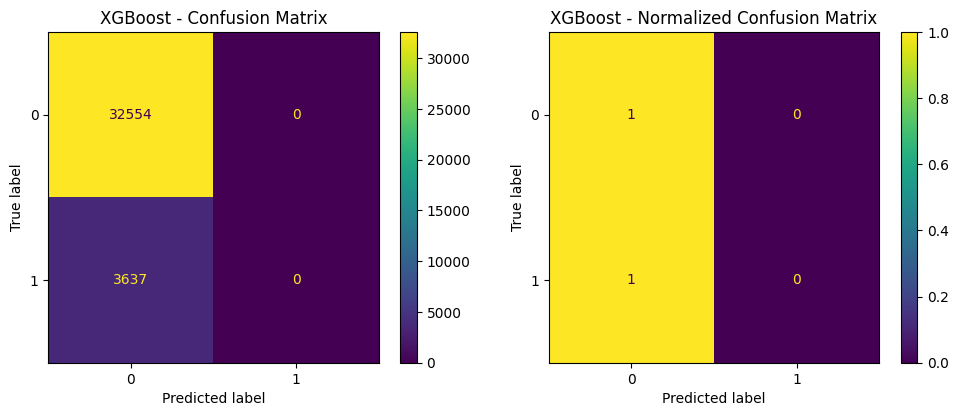


Error rate by category (XGBoost):
 category
Underwear            0.114007
Plus                 0.111392
Intimates            0.110402
Blazers & Jackets    0.108974
Skirts               0.107477
Name: error, dtype: float64

Error rate by country (XGBoost):
 country
Japan            0.123487
Poland           0.109756
Brasil           0.103179
United States    0.102634
France           0.102579
Name: error, dtype: float64

Error rate by basket_size (XGBoost):
 basket_size
2    0.102896
3    0.101626
4    0.101426
1    0.098626
Name: error, dtype: float64


In [9]:
from sklearn.metrics import roc_curve, precision_recall_curve, RocCurveDisplay, PrecisionRecallDisplay

# ROC Curve for both models
plt.figure(figsize=(8, 5))
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
plt.plot(fpr_log, tpr_log, label='Logistic Regression')
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Precision-Recall Curve
plt.figure(figsize=(8, 5))
prec_log, rec_log, _ = precision_recall_curve(y_test, y_prob)
prec_xgb, rec_xgb, _ = precision_recall_curve(y_test, y_prob_xgb)
plt.plot(rec_log, prec_log, label='Logistic Regression')
plt.plot(rec_xgb, prec_xgb, label='XGBoost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Confusion matrices (absolute and normalized)
from sklearn.metrics import ConfusionMatrixDisplay

for model_name, y_pred_ in zip(['Logistic Regression', 'XGBoost'], [y_pred, y_pred_xgb]):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_, ax=axes[0], normalize=None)
    axes[0].set_title(f'{model_name} - Confusion Matrix')
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_, ax=axes[1], normalize='true')
    axes[1].set_title(f'{model_name} - Normalized Confusion Matrix')
    plt.tight_layout()
    plt.show()

# Error breakdown by key segments
segment_cols = ['category', 'country', 'basket_size']
for col in segment_cols:
    error_df = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred_xgb, col: X_test[col]})
    error_df['error'] = error_df['y_true'] != error_df['y_pred']
    error_rate = error_df.groupby(col)['error'].mean().sort_values(ascending=False)
    print(f"\nError rate by {col} (XGBoost):\n", error_rate.head())

## 10. Model Robustness & Validation

We assess model stability using cross-validation and learning curves.

Logistic Regression CV ROC-AUC: 0.499 ± 0.003
XGBoost CV ROC-AUC: 0.655 ± 0.004


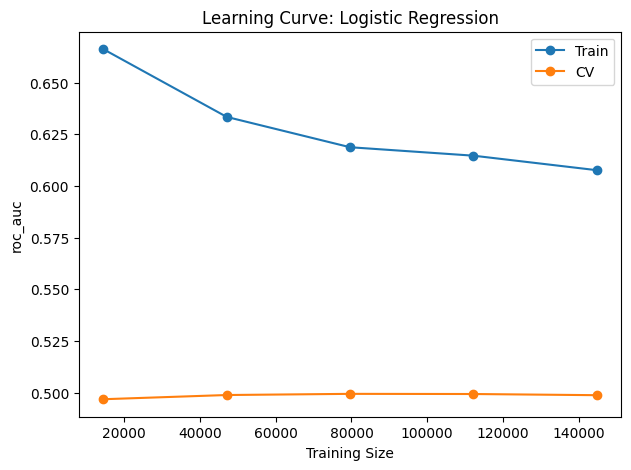

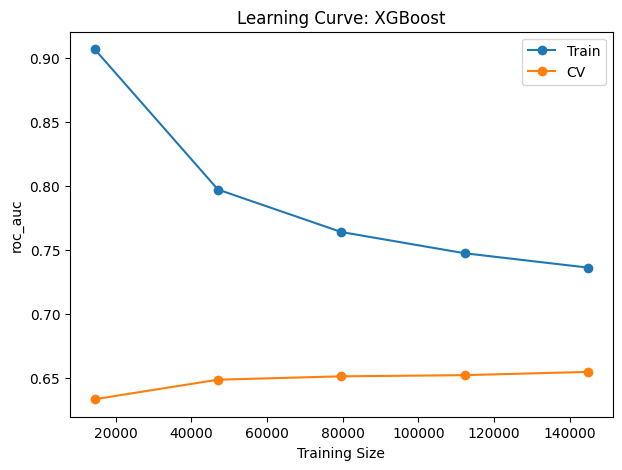

In [10]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import learning_curve

# Cross-validation for both models
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
log_cv_scores = cross_val_score(log_clf, X, y, cv=cv, scoring='roc_auc', n_jobs=1)
xgb_cv_scores = cross_val_score(xgb_clf, X, y, cv=cv, scoring='roc_auc', n_jobs=1)

print(f"Logistic Regression CV ROC-AUC: {log_cv_scores.mean():.3f} ± {log_cv_scores.std():.3f}")
print(f"XGBoost CV ROC-AUC: {xgb_cv_scores.mean():.3f} ± {xgb_cv_scores.std():.3f}")

# Learning curves
def plot_learning_curve(estimator, title, X, y, cv, scoring='roc_auc'):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5), random_state=42
    )
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    plt.figure(figsize=(7, 5))
    plt.plot(train_sizes, train_mean, 'o-', label='Train')
    plt.plot(train_sizes, test_mean, 'o-', label='CV')
    plt.title(title)
    plt.xlabel('Training Size')
    plt.ylabel(scoring)
    plt.legend()
    plt.show()

plot_learning_curve(log_clf, "Learning Curve: Logistic Regression", X, y, cv)
plot_learning_curve(xgb_clf, "Learning Curve: XGBoost", X, y, cv)

## 11. Advanced Interpretability

We use SHAP to explain model predictions and feature effects.

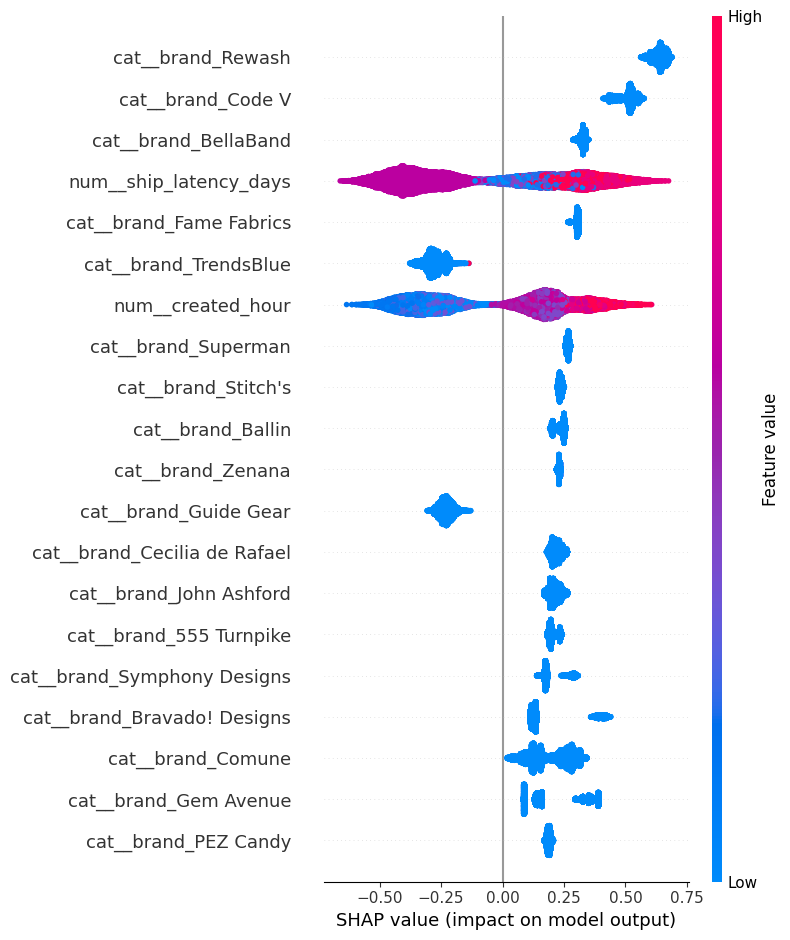

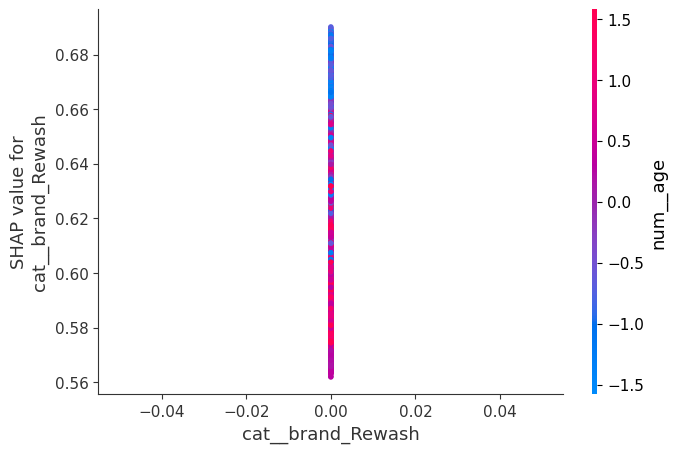

In [12]:
import shap

# SHAP for XGBoost
explainer = shap.Explainer(xgb_clf.named_steps['model'])

# Transform features and ensure dense array
features_transformed = xgb_clf.named_steps['prep'].transform(X_test)
if hasattr(features_transformed, "toarray"):
    features_dense = features_transformed.toarray()
else:
    features_dense = features_transformed

shap_values = explainer(features_dense)

# Global feature importance
shap.summary_plot(
    shap_values, 
    features=features_dense, 
    feature_names=xgb_clf.named_steps['prep'].get_feature_names_out()
)

# SHAP dependence plot for top feature
top_feature = xgb_clf.named_steps['prep'].get_feature_names_out()[np.abs(shap_values.values).mean(0).argmax()]
shap.dependence_plot(
    top_feature, 
    shap_values.values, 
    features_dense, 
    feature_names=xgb_clf.named_steps['prep'].get_feature_names_out()
)

## 12. Business Impact & Recommendations

### Business Impact

- **Potential cost savings:** By identifying likely returns, the business can proactively manage inventory, reduce shipping costs, and improve customer targeting.
- **Risk of false positives:** Incorrectly flagging non-returning customers may lead to lost sales or customer dissatisfaction.
- **Risk of false negatives:** Missing likely returns can increase operational costs.

### Recommendations

1. **Hyperparameter tuning:** Further optimize XGBoost for best performance.
2. **Threshold optimization:** Adjust probability cut-off to balance business trade-offs.
3. **Deploy with monitoring:** Track model performance and retrain as needed.
4. **Integrate SHAP explanations:** Use interpretability tools in dashboards for business users.
5. **Continuous improvement:** Collect feedback, monitor new data, and iterate on features and models.

---

**Next Steps:**
- Present findings to stakeholders.
- Collaborate with business and engineering teams for deployment.
- Plan for regular model evaluation and updates.